In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('ab_data.csv')
df2 = pd.read_csv('countries.csv')

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')

In [7]:
pd.isnull(df).sum()

user_id              0
timestamp       177213
group                0
landing_page         0
converted            0
dtype: int64

In [8]:
df.shape

(294480, 5)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(294479, 5)

In [11]:
df.dropna(inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117267 entries, 0 to 294478
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       117267 non-null  int64         
 1   timestamp     117267 non-null  datetime64[ns]
 2   group         117267 non-null  object        
 3   landing_page  117267 non-null  object        
 4   converted     117267 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 5.4+ MB


In [12]:
df2.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [13]:
pd.isnull(df2).sum()

user_id    0
country    0
dtype: int64

In [14]:
df2.shape

(290586, 2)

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [17]:
df2['country'].value_counts()

country
US    203621
UK     72466
CA     14499
Name: count, dtype: int64

# Now, performing A/B test analysis using statistical tests and running a hypothesis test (Chi-square test since its categorical data) to check significance

In [20]:
# Calculate conversion rates
conversion_rates = df.groupby("group")["converted"].mean()
print("these are the conversion rates: ")
print(conversion_rates)

# Perform statistical test (Chi-square)
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df["group"], df["converted"])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square test p-value: {p}")
if p < 0.05:
    print("Statistically significant difference!")
else:
    print("No significant difference.")

these are the conversion rates: 
group
control      0.121512
treatment    0.117968
Name: converted, dtype: float64
Chi-square test p-value: 0.06291779299958786
No significant difference.


visualizing the above

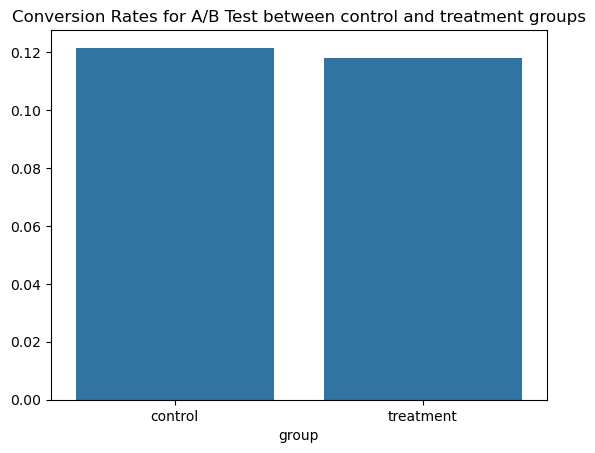

In [22]:
# Conversion rates bar plot
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title("Conversion Rates for A/B Test between control and treatment groups")
plt.show()

# Funnel Analysis: drop off rate between landing page visits and conversions

In [25]:
#counting total users who landed on the page
total_users = df['user_id'].nunique()

# Count users who converted
converted_users = df[df['converted'] == 1]['user_id'].nunique()

# Calculate drop-off rate
drop_off_rate = (total_users - converted_users) / total_users

print(f"Total Users: {total_users}")
print(f"Converted Users: {converted_users}")
print(f"Drop-off Rate: {drop_off_rate:.2%}")  # Display percentage format

Total Users: 116634
Converted Users: 14031
Drop-off Rate: 87.97%


comparing drop off rates for Control vs Treatment groups

In [26]:
# Group-wise drop-off rate calculation
grouped = df.groupby('group').agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
)

grouped['drop_off_rate'] = (grouped['total_users'] - grouped['converted_users']) / grouped['total_users']

print(grouped[['converted_users', 'drop_off_rate']])

           converted_users  drop_off_rate
group                                    
control               7106       0.878165
treatment             6935       0.881704


# Since the drop off rate is similar, the change did not improve the funnel efficiency.

Now, doing a time based trend analysis

In [29]:
# Group by date and calculate conversion rate
daily_trend = df.groupby('date').agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
)

# Calculate conversion rate per day
daily_trend['conversion_rate'] = daily_trend['converted_users'] / daily_trend['total_users']

print(daily_trend.head())  # Check the first few rows

            total_users  converted_users  conversion_rate
date                                                     
2025-03-03       116634            14041         0.120385


plotting the conversion rate trend

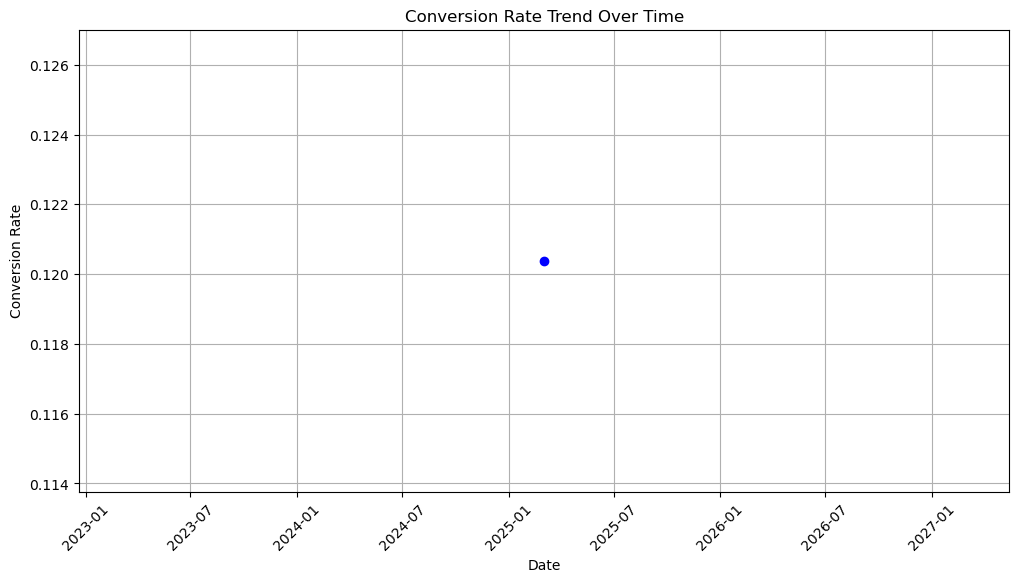

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_trend.index, daily_trend['conversion_rate'], marker='o', linestyle='-', color='b')

plt.title('Conversion Rate Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

comparing control vs treatment trends

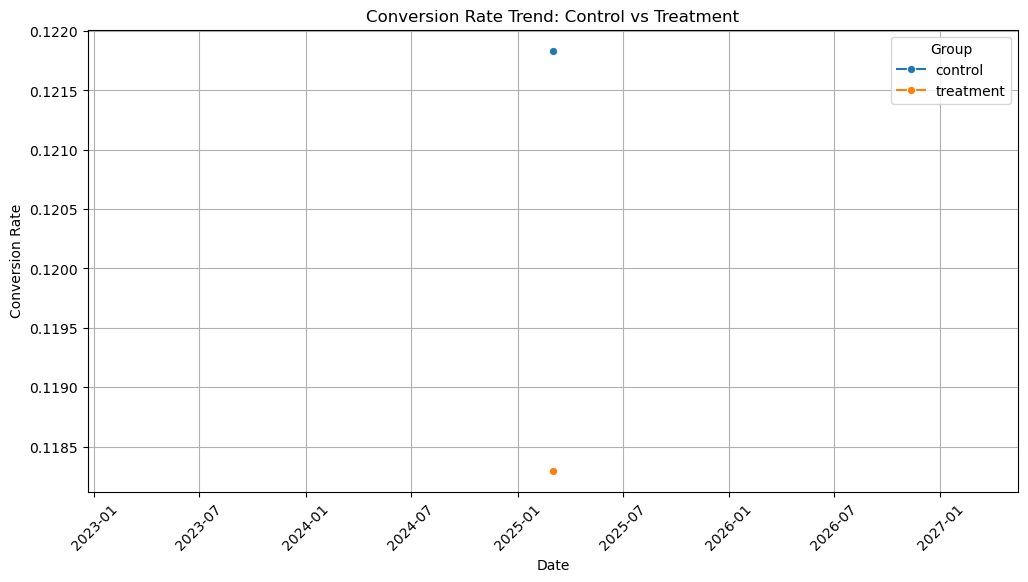

In [31]:
# Group data by date & group type (control/treatment)
group_trend = df.groupby(['date', 'group']).agg(
    converted_users=('converted', 'sum'),
    total_users=('user_id', 'nunique')
).reset_index()

# Calculate conversion rate for each group
group_trend['conversion_rate'] = group_trend['converted_users'] / group_trend['total_users']

# Plot conversion rate trends for both groups
plt.figure(figsize=(12, 6))
sns.lineplot(data=group_trend, x='date', y='conversion_rate', hue='group', marker='o')

plt.title('Conversion Rate Trend: Control vs Treatment')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Group")
plt.show()

# User Segmentation (Data Analysis & Business Analysis)

analyzing conversion rates for each landing page

In [32]:
# Group by landing page and calculate conversion rate
landing_page_segmentation = df.groupby('landing_page').agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
)

# Calculate conversion rate for each page
landing_page_segmentation['conversion_rate'] = landing_page_segmentation['converted_users'] / landing_page_segmentation['total_users']

print(landing_page_segmentation)

              total_users  converted_users  conversion_rate
landing_page                                               
new_page            58642             6916         0.117936
old_page            58309             7125         0.122194


segregating users by their conversion behaviour

In [35]:
conversion_segmentation = df.groupby('converted')['user_id'].nunique()

# Calculate percentage
conversion_percentage = (conversion_segmentation / conversion_segmentation.sum()) * 100

# Combine both into a DataFrame
conversion_summary = pd.DataFrame({
    'Count': conversion_segmentation,
    'Percentage': conversion_percentage
})

# Print the result
print(conversion_summary)

            Count  Percentage
converted                    
0          102752   87.985409
1           14031   12.014591


analyzing users' conversion probability based on no of site visits

In [36]:
# Count visits per user
user_visits = df.groupby('user_id').size()

# Categorize users based on visit frequency
df['visit_category'] = df['user_id'].map(lambda x: 'Frequent' if user_visits[x] > 3 else 'Occasional')

# Check conversion rates by visit frequency
visit_segmentation = df.groupby('visit_category').agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
)

visit_segmentation['conversion_rate'] = visit_segmentation['converted_users'] / visit_segmentation['total_users']

print(visit_segmentation)

                total_users  converted_users  conversion_rate
visit_category                                               
Occasional           116634            14041         0.120385


comparing control vs treatment group segments

In [38]:
group_segmentation = df.groupby(['group', 'converted']).agg(
    total_users=('user_id', 'nunique')
).unstack()

print(group_segmentation)

          total_users      
converted           0     1
group                      
control         51256  7106
treatment       51738  6929


control group has a higher retention rate

visualizing user segments

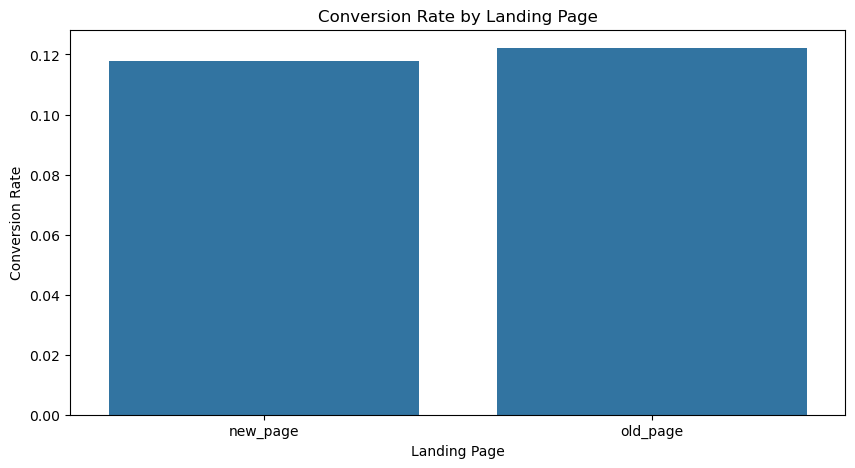

In [40]:
plt.figure(figsize=(10, 5))
sns.barplot(x=landing_page_segmentation.index, y=landing_page_segmentation['conversion_rate'])
plt.title("Conversion Rate by Landing Page")
plt.xlabel("Landing Page")
plt.ylabel("Conversion Rate")
plt.show()

# calculating conversion rate by country

In [42]:
# Merge datasets on user_id
df_merged = df.merge(df2, on='user_id', how='left')

# Check the first few rows
print(df_merged.head())

   user_id           timestamp      group landing_page  converted        date  \
0   851104 2025-03-03 11:48:36    control     old_page          0  2025-03-03   
1   804228 2025-03-03 01:45:12    control     old_page          0  2025-03-03   
2   936923 2025-03-03 20:49:06    control     old_page          0  2025-03-03   
3   839785 2025-03-03 11:06:36  treatment     new_page          1  2025-03-03   
4   803683 2025-03-03 05:16:12  treatment     new_page          0  2025-03-03   

  visit_category country  
0     Occasional      US  
1     Occasional      US  
2     Occasional      US  
3     Occasional      CA  
4     Occasional      US  


analyzing conversion rate by country

In [43]:
# Group by country and calculate conversion rates
country_conversion = df_merged.groupby('country').agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
)

# Compute conversion rate per country
country_conversion['conversion_rate'] = country_conversion['converted_users'] / country_conversion['total_users']

# Sort in descending order
country_conversion = country_conversion.sort_values(by='conversion_rate', ascending=False)

print(country_conversion)

         total_users  converted_users  conversion_rate
country                                               
US             81662             9902         0.121256
UK             29190             3486         0.119424
CA              5782              653         0.112937


The US had 12% conversion rate whereas the UK and Canada had an 11% conversion rate

Geographic trends in A/B testing results:

In [44]:
# Compare conversion rate by country for control vs treatment group
country_ab_test = df_merged.groupby(['country', 'group']).agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
)

# Compute conversion rate
country_ab_test['conversion_rate'] = country_ab_test['converted_users'] / country_ab_test['total_users']

print(country_ab_test)

                   total_users  converted_users  conversion_rate
country group                                                   
CA      control           2895              340         0.117444
        treatment         2902              313         0.107857
UK      control          14649             1757         0.119940
        treatment        14612             1729         0.118327
US      control          40781             5009         0.122827
        treatment        41110             4893         0.119022


Users from the US have a slightly higher conversion rate, irrespective of which group they belong to

plotting conversion rates by country:

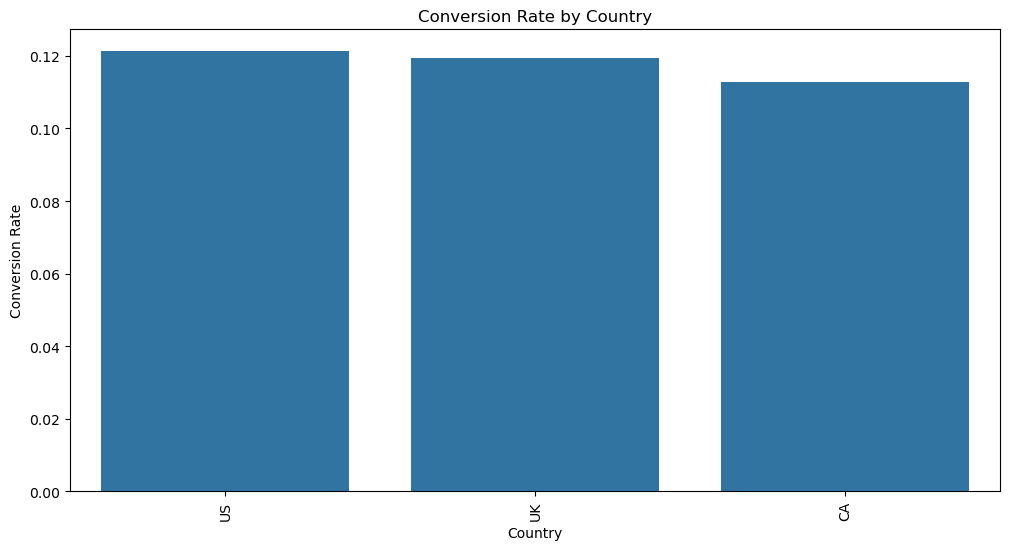

In [45]:
plt.figure(figsize=(12, 6))
sns.barplot(x=country_conversion.index, y=country_conversion['conversion_rate'])
plt.xticks(rotation=90)
plt.title("Conversion Rate by Country")
plt.xlabel("Country")
plt.ylabel("Conversion Rate")
plt.show()

Although the conversion rate is between 10-12% (depending on control/treatment groups), Canadian users are the least likely to convert among the 3 countries, with American users being the first.